In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from truncation import get_truncation

In [2]:
# %matplotlib widget
%matplotlib inline

In [3]:
FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


In [4]:
def relative_diff(*args):
    return (max(args) - min(args))/np.mean(args)

In [5]:
src_incl = "He_photodis/incl_10pp40/"
src = "He_photodis/HE_2NF/"
forces = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]

## ppn

### Exclusive

In [17]:
files = [file for file in os.listdir(src) if "incl" not in file and file.startswith("ppn")] 

In [6]:
# fname = files40[0]
def read_data(fname):
    df = pd.read_csv(src + fname, skiprows=1, skipinitialspace=True, sep=" ")
    df["Energy"] = float(fname.split("-")[2])
    df["FORCE"] = fname.split("-")[3].split("_")[-1]
    df["CUTOFF"] = int(fname.split("-")[1][-3:])
    return df

In [18]:
# df1 = pd.concat([read_data(fname) for fname in files], ignore_index=True)

In [22]:
# df1.sort_values("SLANGE", inplace=True)

In [24]:
# df1.to_csv("HE_pnn_excl.csv", index=False)

In [9]:
df1 = pd.read_csv("HE_pnn_excl.csv")

In [10]:
df1.head()

,I,SLANGE,CROSS,E1,E2,E3,Energy,FORCE,CUTOFF
0,1,0.5,3.562000e-08,60.368,0.009,31.905,100.0,N3LO,450
1,1,0.5,3.416000e-08,60.368,0.009,31.905,100.0,N3LO,400
2,1,0.5,2.725000e-08,60.368,0.009,31.905,100.0,NLO,400
3,1,0.5,3.580000e-08,60.368,0.009,31.905,100.0,N4LO+,500
4,1,0.5,2.912000e-07,12.845,0.030,9.407,30.0,N4LO,400


#### Truncation

/tmp/ipykernel_400781/2717547641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("SLANGE", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas

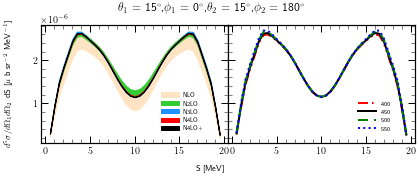

In [127]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.suptitle("$\\theta_1$ = {}$^\circ$,"
             "$\\phi_1$ = {}$^\circ$,"
             "$\\theta_2$ = {}$^\circ$,"
             "$\\phi_2$ = {}$^\circ$".format(15, 0, 15, 180), y=0.9)
fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [$\mu$ b sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                   & (df1["FORCE"] == force) ]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, df_tmp["CROSS"].values+df_trunc[force].values,
                            df_tmp["CROSS"].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                   & (df1["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="lower right", bbox_to_anchor=(0.4, 0.05, 0.5, 0.5))
plt.tight_layout()

plt.savefig(f"Figures_HE/CROSS_excl_trunc_{en}mev.pdf", dpi=600, facecolor="white")


In [28]:
df_tmp = df1[(df1.CUTOFF == 450) &
(df1.FORCE.isin(["N4LO", "N4LO+"])) &
                (df1.Energy == 30)]

In [30]:
reldif = df_tmp.pivot(index="SLANGE", columns="FORCE")["CROSS"].apply(lambda x: relative_diff(*x), axis=1)*100

In [58]:
order="N4LO+"
df_tmp = df1[(df1.FORCE == order) &
                    (df1.CUTOFF == 450) &
                    (df1.Energy == 30)][["SLANGE", "CROSS"]]
df_tmp["CROSS+"] = df_tmp["CROSS"] + df_trunc[order].values
df_tmp["CROSS-"] = df_tmp["CROSS"] - df_trunc[order].values

In [80]:
(df_tmp[["CROSS-", "CROSS+"]].apply(lambda x: relative_diff(*x), axis=1)*100)\
            .sort_values(ascending=False).loc[1251]

0.1264591278621783

In [79]:
df_tmp.loc[1251]

SLANGE    10.003000
CROSS      0.000001
CROSS+     0.000001
CROSS-     0.000001
Name: 1251, dtype: float64

In [82]:
df_tmp = df1[(df1.FORCE == "N4LO+") &
                    (df1.Energy == 30)]
reldif2 = df_tmp.pivot(index="SLANGE", columns="CUTOFF")["CROSS"].apply(lambda x: relative_diff(*x), axis=1)*100

In [88]:
reldif2.iloc[:40]

SLANGE
0.500     9.138211
1.001     9.042386
1.501     7.691022
2.000     6.081173
2.502     5.157993
3.001     4.681934
3.502     4.103343
4.001     3.294207
4.502     2.461178
5.003     1.826113
5.502     1.310228
6.002     0.886623
6.501     0.614004
7.000     0.410467
7.502     0.283889
8.001     0.254130
8.501     0.427807
9.001     0.632161
9.503     0.764981
10.003    0.784314
10.502    0.762389
11.001    0.550639
11.501    0.425456
12.001    0.252685
12.502    0.282207
13.001    0.357553
13.502    0.611621
14.002    0.928279
14.500    1.307190
15.002    1.862348
15.503    2.534113
16.002    3.366112
16.501    4.148825
17.001    4.708291
17.501    5.196629
18.001    6.187543
18.501    7.800577
19.002    9.090909
19.501    9.126560
dtype: float64

/tmp/ipykernel_400781/2869571843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("SLANGE", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas

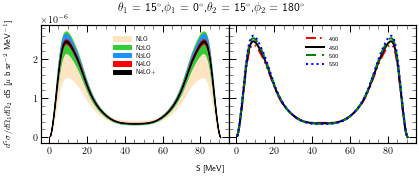

In [96]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=100

df_tmp = df1[(df1.CUTOFF == 450) &
             (df1.Energy == en)]
df_tmp.sort_values("SLANGE", inplace=True)
df_piv = df_tmp.pivot(index="SLANGE", columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
fig.suptitle("$\\theta_1$ = {}$^\circ$,"
             "$\\phi_1$ = {}$^\circ$,"
             "$\\theta_2$ = {}$^\circ$,"
             "$\\phi_2$ = {}$^\circ$".format(15, 0, 15, 180), y=0.9)
fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [$\mu$ b sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES[1:]:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                   & (df1["FORCE"] == force) ]
    # axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.SLANGE, df_tmp["CROSS"].values+df_trunc[force].values,
                            df_tmp["CROSS"].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                   & (df1["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    # ax.set_xticks(np.arange(0, 180+j-1, 30))
    # ax.set_xlim([0, 180])
    # ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3, loc="upper center", bbox_to_anchor=(0., 0.45, 1., 0.5))
plt.tight_layout()

plt.savefig(f"Figures_HE/CROSS_excl_trunc_{en}mev.pdf", dpi=600, facecolor="white")


In [114]:
order="N4LO+"
en = 100
df_tmp = df1[(df1.FORCE == order) &
                    (df1.CUTOFF == 450) &
                    (df1.Energy == en)][["SLANGE", "CROSS"]]
df_tmp["CROSS+"] = df_tmp["CROSS"] + df_trunc[order].values
df_tmp["CROSS-"] = df_tmp["CROSS"] - df_trunc[order].values

In [115]:
(df_tmp[df_tmp["SLANGE"] == 10.001][["CROSS-", "CROSS+"]].apply(lambda x: relative_diff(*x), axis=1)*100).sort_values(ascending=False).iloc[:10]

1242    2.147389
dtype: float64

In [116]:
df_tmp[df_tmp["SLANGE"] == 10.001]

,SLANGE,CROSS,CROSS+,CROSS-
1242,10.001,0.000002,0.000002,0.000002


In [120]:
df_tmp = df1[(df1.FORCE == "N4LO+") &
                    (df1.Energy == en)]
reldif2 = df_tmp.pivot(index="SLANGE", columns="CUTOFF")["CROSS"].apply(lambda x: relative_diff(*x), axis=1)*100

In [126]:
reldif2.head(20)

SLANGE
0.500     10.690614
1.003     10.574713
1.500     10.538966
2.005     10.423890
2.502     10.353633
3.005     10.264709
3.506     10.146252
4.003     10.113208
4.503      9.987113
5.006      9.971671
5.504      9.882232
6.003      9.790706
6.503      9.663772
7.004      9.546133
7.504      9.470637
8.005      9.379758
8.504      9.296710
9.002      9.200482
9.507      9.072581
10.001     8.979177
dtype: float64

#### ORDER

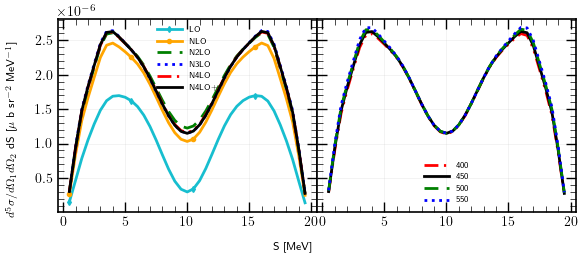

In [10]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en=30
fig = plt.figure(figsize=(6, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
# fig.supylabel("d\sigma", x=0.03, y=0.6, size=12)
fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [$\mu$ b sr$^{-2}$ MeV$^{-1}$]", size=8)
fig.supxlabel("S [MeV]", size=8, y=0.06)

for force in FORCES:
    df_tmp =  df1[(df1["CUTOFF"]==450) & (df1["Energy"] == en)
                   & (df1["FORCE"] == force) ]
    axes[0].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **line_styles[force], label=force)
for cut in CUTOFF:
    df_tmp =  df1[(df1["CUTOFF"]==cut) & (df1["Energy"] == en)
                   & (df1["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["SLANGE"], df_tmp["CROSS"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    # ax.set_xticks(np.arange(0, 180+j-1, 30))
    # ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=6, handlelength=3)
plt.tight_layout()

# plt.savefig(f"Figures_HE/CROSS_excl_{en}mev.pdf", dpi=300, facecolor="white")

### Inclusive

In [6]:
files_inc = [file for file in os.listdir(src)
             if "incl" in file and file.startswith("ppn")] 

In [7]:
files_inc2 = os.listdir(src_incl) 

In [33]:
def read_data_incl(fname, src=src):
    df = pd.read_csv(src + fname, skiprows=8, skipinitialspace=True, sep=" ")
    df["FORCE"] = fname.split("-")[3].split("_")[-1]
    try:
        df["CUTOFF"] = int(fname.split("-")[1][-3:])
        df["Energy"] = float(fname.split("-")[2])
    except:
        df["CUTOFF"] = int(fname.split("-")[2][-3:])
        df["Energy"] = float(fname.split("-")[1])
    if fname.split("-")[-2] == "incl":
        df["angle"] = int(fname.split("-")[-1][:-3])
    else:
        df["angle"] = int(fname.split("-")[-4][:-3])
    return df

In [34]:
# df2 = pd.concat([read_data_incl(fname, src=src_incl) for fname in files_inc2], ignore_index=True)

In [35]:
# df2.sort_values("E1", inplace=True)

In [36]:
# df2.to_csv("HE_pnn_incl_new_angles_10pp40.csv", index=False)

In [8]:
df2 = pd.read_csv("HE_pnn_incl_new_angles_10pp40.csv")

In [9]:
import matplotlib.ticker

In [10]:
def create_subtitle(fig: plt.Figure, grid: mpl.gridspec.SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', y=0.88)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_18762/2517126906.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


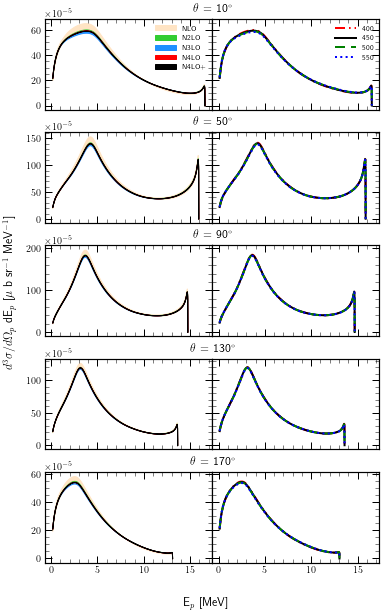

In [29]:
# for en in [30]:
en = 30
df_tmp = df2[(df2.CUTOFF == 450) & (df2["Energy"] == en)]
df_tmp.sort_values("E1", inplace=True)
df_piv = df_tmp.pivot(index=["E1", "angle"], columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_piv = df_piv.reset_index(level=1)


fig = plt.figure(figsize=(6, 10))
gs = fig.add_gridspec(ncols=2, nrows=5, wspace=0, hspace=0.25)
axes = gs.subplots(sharey="row", sharex="col")
obs = "CROSS"
fig.supylabel("$d^3\sigma/d\Omega _p$ dE$_p$ [$\mu$ b sr$^{-1}$ MeV$^{-1}$]", size=12, x=0.03)
fig.supxlabel("E$_p$ [MeV]", size=12, y=0.06)
for i, angle in enumerate(np.sort(df2["angle"].unique())):
    axes[i, 0].ticklabel_format(axis="y", style="sci", scilimits=(-5, -5))
    create_subtitle(fig, gs[i, 0:2], f"$\\theta$ = {angle}$^\circ$")
    
    df_trunc = get_truncation(df_piv[df_piv.angle == angle].drop(
        "angle", axis=1), en, Lambda=650)
    for force in FORCES[1:]:
        df_tmp =  df2[(df2["CUTOFF"]==450) & (df2["Energy"] == en)
                        & (df2["FORCE"] == force) & (df2["angle"] == angle)]
        axes[i, 0].fill_between(df_tmp["E1"], df_tmp["CROSS"].values+df_trunc[force].values,
                             df_tmp["CROSS"].values-df_trunc[force].values, label=force,
                             color=trunc_colors[force])
        # axes[i, 0].plot(df_tmp["E1"], df_tmp[obs], **line_styles[force], label=force)
    for cut in CUTOFF:
        df_tmp =  df2[(df2["CUTOFF"]==cut) & (df2["Energy"] == en)
                        & (df2["FORCE"] == "N4LO+") & (df2["angle"] == angle)]
        axes[i, 1].plot(df_tmp["E1"], df_tmp[obs], **ls_cutoff[cut], label=cut)
    for j, ax in enumerate(axes[i]):
        ax.tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                    length=7, width=1, top=True, right=True, zorder=1)
        # ax.grid(alpha=0.2)
        ax.set_zorder(-1)
axes[0,0].legend(fontsize=7, handlelength=3)
axes[0,1].legend(fontsize=7, handlelength=3)
plt.tight_layout()
plt.savefig(f"Figures_HE/{obs}_incl_trunc_{en}mev_all.pdf", dpi=300, facecolor="white")
    # plt.close()
plt.show()


In [74]:
order = "N4LO+"
en = 100
angle = 10
df_tmp = df2[(df2.CUTOFF == 450) & (df2["Energy"] == en)]
df_tmp.sort_values("E1", inplace=True)
df_piv = df_tmp.pivot(index=["E1", "angle"], columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_piv = df_piv.reset_index(level=1)
for angle in np.arange(10, 180,40):
    df_trunc = get_truncation(df_piv[df_piv.angle == angle].drop(
        "angle", axis=1), en, Lambda=650)
    df_tmp = df2[(df2.FORCE == order) &
                (df2.CUTOFF == 450) &
                (df2.Energy == en) &
                (df2.angle == angle)][["E1", "CROSS"]]
    df_tmp["CROSS+"] = df_tmp["CROSS"] + df_trunc[order].values
    df_tmp["CROSS-"] = df_tmp["CROSS"] - df_trunc[order].values

    print("angle:", angle)
    print("%.2f percent" % (df_tmp.iloc[(df_tmp['E1']-1.463).abs().argsort()[:1]][["CROSS-", "CROSS+"]]
        .apply(lambda x: relative_diff(*x), axis=1)*100).values[0])
    # print("%.2f percent" % (df_tmp.iloc[(df_tmp['E1']-3.882).abs().argsort()[:1]][["CROSS-", "CROSS+"]]
    #     .apply(lambda x: relative_diff(*x), axis=1)*100).values[0])


angle: 10
1.68 percent
angle: 50
1.67 percent
angle: 90
1.56 percent
angle: 130
1.43 percent
angle: 170
1.42 percent


In [160]:
order = "N4LO+"
en = 100
for angle in np.arange(10, 180, 40):
    df_tmp = df2[(df2.FORCE == order) &
                (df2.Energy == en) &
                (df2.angle == angle)]
    reldif2 = (df_tmp.pivot(index="E1", columns="CUTOFF")[
        "CROSS"].apply(lambda x: relative_diff(*x), axis=1)*100).reset_index()
    print("angle:", angle)
    # print("%.2f percent" % (reldif2.iloc[(df_tmp['E1']-1.463).abs().argsort()[:1]])
    # print("%.2f percent" % (reldif2.iloc[(df_tmp['E1']-3.882).abs().argsort()[:1]]))
    print("%.2f percent" %
        #   reldif2.iloc[(reldif2['E1']-3.882).abs().argsort()[:1]][0].values[0])
      reldif2.iloc[(reldif2['E1']-1.463).abs().argsort()[:1]][0].values[0])


angle: 10
7.62 percent
angle: 50
9.39 percent
angle: 90
7.99 percent
angle: 130
6.57 percent
angle: 170
5.90 percent


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_18762/3801803516.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


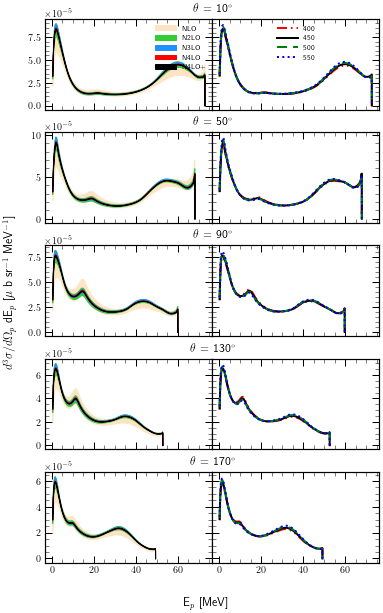

In [28]:
# for en in [30]:
en = 100
df_tmp = df2[(df2.CUTOFF == 450) & (df2["Energy"] == en)]
df_tmp.sort_values("E1", inplace=True)
df_piv = df_tmp.pivot(index=["E1", "angle"], columns="FORCE")[
    "CROSS"].reindex(FORCES, axis=1)
df_piv = df_piv.reset_index(level=1)


fig = plt.figure(figsize=(6, 10))
gs = fig.add_gridspec(ncols=2, nrows=5, wspace=0, hspace=0.25)
axes = gs.subplots(sharey="row", sharex="col")
obs = "CROSS"
fig.supylabel("$d^3\sigma/d\Omega _p$ dE$_p$ [$\mu$ b sr$^{-1}$ MeV$^{-1}$]", size=12, x=0.03)
fig.supxlabel("E$_p$ [MeV]", size=12, y=0.06)
for i, angle in enumerate(np.sort(df2["angle"].unique())):
    axes[i, 0].ticklabel_format(axis="y", style="sci", scilimits=(-5, -5))
    create_subtitle(fig, gs[i, 0:2], f"$\\theta$ = {angle}$^\circ$")
    
    df_trunc = get_truncation(df_piv[df_piv.angle == angle].drop(
        "angle", axis=1), en, Lambda=650)
    for force in FORCES[1:]:
        df_tmp =  df2[(df2["CUTOFF"]==450) & (df2["Energy"] == en)
                        & (df2["FORCE"] == force) & (df2["angle"] == angle)]
        axes[i, 0].fill_between(df_tmp["E1"], df_tmp["CROSS"].values+df_trunc[force].values,
                             df_tmp["CROSS"].values-df_trunc[force].values, label=force,
                             color=trunc_colors[force])
        # axes[i, 0].plot(df_tmp["E1"], df_tmp[obs], **line_styles[force], label=force)
    for cut in CUTOFF:
        df_tmp =  df2[(df2["CUTOFF"]==cut) & (df2["Energy"] == en)
                        & (df2["FORCE"] == "N4LO+") & (df2["angle"] == angle)]
        axes[i, 1].plot(df_tmp["E1"], df_tmp[obs], **ls_cutoff[cut], label=cut)
    for j, ax in enumerate(axes[i]):
        ax.tick_params(which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                    length=7, width=1, top=True, right=True, zorder=1)
        # ax.grid(alpha=0.2)
        ax.set_zorder(-1)
axes[0,0].legend(fontsize=7, handlelength=3)
axes[0,1].legend(fontsize=7, handlelength=3)
plt.tight_layout()
# plt.savefig(f"Figures_HE/{obs}_incl_trunc_{en}mev_all.pdf", dpi=300, facecolor="white")
    # plt.close()
plt.show()


## Nd

In [76]:
files = [file for file in os.listdir(src) if "incl" not in file and file.startswith("CrossHe")] 

In [85]:
# fname = files40[0]
def read_data_nd(fname):
    df = pd.read_csv(src + fname, skipinitialspace=True, sep=" ", names=["I", "angle", "CROSS", "CROSS2"])
    df["FORCE"] = fname.split("-")[2]
    df["Energy"] = float(fname.split("-")[3].split("_")[-1])
    df["CUTOFF"] = int(fname.split("-")[1][-3:])
    return df


In [86]:
# df3 = pd.concat([read_data_nd(fname) for fname in files], ignore_index=True)
# df3.sort_values("angle", inplace=True)
# df3.to_csv("HE_nd.csv", index=False)


In [95]:
df3 = pd.read_csv("HE_nd.csv")

#### Truncation

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


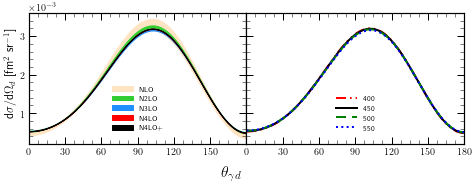

In [168]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en = 30
df_tmp = df3[(df3.CUTOFF == 450) &
             (df3.Energy == en)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="I", columns="FORCE")[
    "CROSS2"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

fig = plt.figure(figsize=(7, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
fig.supylabel(
    "d$\sigma$/d$\Omega_d$ [fm$^2$ sr$^{-1}$]", x=0.05, y=0.6, size=12)
fig.supxlabel("$\\theta_{\gamma d}$", y=0.06, size=16)
# fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [sr$^{-1}$ fm$^{2}$]", size=8)

for force in FORCES[1:]:
    df_tmp = df3[(df3["CUTOFF"] == 450) & (df3["Energy"] == en)
                 & (df3["FORCE"] == force)]
    # axes[0].plot(df_tmp["angle"], df_tmp["CROSS2"],
    #              **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.angle, df_tmp["CROSS2"].values+df_trunc[force].values[::-1],
                         df_tmp["CROSS2"].values-df_trunc[force].values[::-1], label=force,
                         color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp = df3[(df3["CUTOFF"] == cut) & (df3["Energy"] == en)
                 & (df3["FORCE"] == "N4LO+")]
    axes[1].plot(df_tmp["angle"], df_tmp["CROSS2"],
                 **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0, 180])
    # ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=7, handlelength=3, loc= "lower center",bbox_to_anchor=(0, 0.05, 1,1))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
plt.tight_layout()
plt.savefig(f"Figures_HE/CROSS_nd_trunc_{en}mev.pdf", dpi=300, facecolor="white")


In [136]:
order = "NLO"
en = 100
for order in FORCES[1:]:
    df_tmp = df3[(df3.CUTOFF == 450) &
                (df3.Energy == en)]
    df_tmp.sort_values("angle", inplace=True)
    df_piv = df_tmp.pivot(index="I", columns="FORCE")[
        "CROSS2"].reindex(FORCES, axis=1)
    df_trunc = get_truncation(df_piv, en, Lambda=650)
    df_tmp = df3[(df3.FORCE == order) &
                    (df3.CUTOFF == 450) &
                    (df3.Energy == en)][["angle", "CROSS2"]]
    df_tmp["CROSS+"] = df_tmp["CROSS2"] + df_trunc[order].values
    df_tmp["CROSS-"] = df_tmp["CROSS2"] - df_trunc[order].values

    print("order:", order)
    # print("%.2f percent" % (df_tmp.iloc[(df_tmp['angle']-105).abs().argsort()[:1]][["CROSS-", "CROSS+"]]
                            # .apply(lambda x: relative_diff(*x), axis=1)*100).sort_values(ascending=False).values[0])
    print("%.2f percent" % (df_tmp.iloc[(df_tmp['angle']-120).abs().argsort()[:1]][["CROSS-", "CROSS+"]]
                            .apply(lambda x: relative_diff(*x), axis=1)*100).sort_values(ascending=False).values[0])
    # print("%.2f percent" % (df_tmp.iloc[(df_tmp['E1']-3.882).abs().argsort()[:1]][["CROSS-", "CROSS+"]]
    #     .apply(lambda x: relative_diff(*x), axis=1)*100).values[0])


order: NLO
8.75 percent
order: N2LO
4.73 percent
order: N3LO
2.15 percent
order: N4LO
1.21 percent
order: N4LO+
0.45 percent


In [162]:
order = "N4LO+"
en = 100
df_tmp = df3[(df3.FORCE == order) &
            (df3.Energy == en)]
reldif2 = (df_tmp.pivot(index="angle", columns="CUTOFF")[
    "CROSS2"].apply(lambda x: relative_diff(*x), axis=1)*100).reset_index()
# print("%.2f percent" % (reldif2.iloc[(df_tmp['E1']-1.463).abs().argsort()[:1]])
# print("%.2f percent" % (reldif2.iloc[(df_tmp['E1']-3.882).abs().argsort()[:1]]))
print("%.2f percent" %
        # reldif2.iloc[(reldif2['angle']-105).abs().argsort()[:1]][0].values[0])
        reldif2.iloc[(reldif2['angle']-120).abs().argsort()[:1]][0].values[0])


4.01 percent


/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


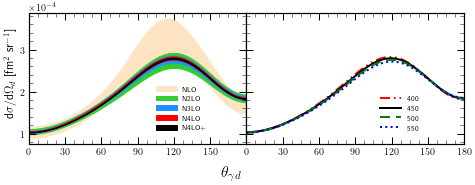

In [165]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en = 100
df_tmp = df3[(df3.CUTOFF == 450) &
             (df3.Energy == en)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="I", columns="FORCE")[
    "CROSS2"].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, en, Lambda=650)

fig = plt.figure(figsize=(7, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
fig.supylabel(
    "d$\sigma$/d$\Omega_d$ [fm$^2$ sr$^{-1}$]", x=0.05, y=0.6, size=12)
fig.supxlabel("$\\theta_{\gamma d}$", y=0.06, size=16)
# fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [sr$^{-1}$ fm$^{2}$]", size=8)

for force in FORCES[1:]:
    df_tmp = df3[(df3["CUTOFF"] == 450) & (df3["Energy"] == en)
                 & (df3["FORCE"] == force)]
    # axes[0].plot(df_tmp["angle"], df_tmp["CROSS2"],
    #              **line_styles[force], label=force)
    axes[0].fill_between(df_tmp.angle, df_tmp["CROSS2"].values+df_trunc[force].values[::-1],
                         df_tmp["CROSS2"].values-df_trunc[force].values[::-1], label=force,
                         color=trunc_colors[force])
for cut in CUTOFF:
    df_tmp = df3[(df3["CUTOFF"] == cut) & (df3["Energy"] == en)
                 & (df3["FORCE"] == "N4LO+")]
    axes[1].plot(df_tmp["angle"], df_tmp["CROSS2"],
                 **ls_cutoff[cut], label=cut)

for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0, 180])
    # ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=7, handlelength=3, loc= "lower center",bbox_to_anchor=(0.2, 0.05, 1,1))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
plt.tight_layout()
plt.savefig(f"Figures_HE/CROSS_nd_trunc_{en}mev.pdf", dpi=300, facecolor="white")


#### ORDER

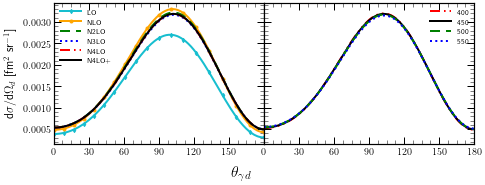

In [7]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en = 30
fig = plt.figure(figsize=(7, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
fig.supylabel("d$\sigma$/d$\Omega_d$ [fm$^2$ sr$^{-1}$]", x=0.03, y=0.6, size=12)
fig.supxlabel("$\\theta_{\gamma d}$", y=0.06, size=16)
# fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [sr$^{-1}$ fm$^{2}$]", size=8)

for force in FORCES:
    df_tmp =  df3[(df3["CUTOFF"]==450) & (df3["Energy"] == en)
                   & (df3["FORCE"] == force) ]
    axes[0].plot(df_tmp["angle"], df_tmp["CROSS2"], **line_styles[force], label=force)
for cut in CUTOFF:
    df_tmp =  df3[(df3["CUTOFF"]==cut) & (df3["Energy"] == en)
                   & (df3["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["angle"], df_tmp["CROSS2"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0, 180])
    # ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=7, handlelength=3)
plt.tight_layout()
# plt.savefig(f"Figures_HE/CROSS_nd_{en}mev.pdf", dpi=300, facecolor="white")

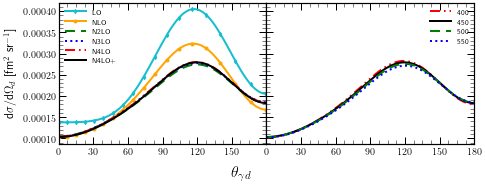

In [52]:
# fig, axes = plt.subplots(1,2, figsize=(7,2.8))
en = 100
fig = plt.figure(figsize=(7, 2.8))
gs = fig.add_gridspec(ncols=2, wspace=0)
axes = gs.subplots(sharey=True)
# fig.suptitle(f"Exclusive at energy 120[MeV]")
fig.supylabel("d$\sigma$/d$\Omega_d$ [fm$^2$ sr$^{-1}$]", x=0.03, y=0.6, size=12)
fig.supxlabel("$\\theta_{\gamma d}$", y=0.06, size=16)
# fig.supylabel("$d^5\sigma/d\Omega _1 d\Omega _2$ dS [sr$^{-1}$ fm$^{2}$]", size=8)

for force in FORCES:
    df_tmp =  df3[(df3["CUTOFF"]==450) & (df3["Energy"] == en)
                   & (df3["FORCE"] == force) ]
    axes[0].plot(df_tmp["angle"], df_tmp["CROSS2"], **line_styles[force], label=force)
for cut in CUTOFF:
    df_tmp =  df3[(df3["CUTOFF"]==cut) & (df3["Energy"] == en)
                   & (df3["FORCE"] == "N4LO+") ]
    axes[1].plot(df_tmp["angle"], df_tmp["CROSS2"], **ls_cutoff[cut], label=cut)
for j, ax in enumerate(axes):
    ax.tick_params(which='minor', direction='in', length=4,
                   width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                   length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j, 30))
    ax.set_xlim([0, 180])
    # ax.grid(alpha=0.2)
    ax.set_zorder(-1)
    ax.legend(fontsize=7, handlelength=3)
plt.tight_layout()
# plt.savefig(f"Figures_HE/CROSS_nd_{en}mev.pdf", dpi=300, facecolor="white")